In [1]:
import sys
import tensorflow as tf
import torch
import numpy as np
import skimage.io as io
import os

from utilities import get_files_ending_with

2022-03-07 22:21:35.383227: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib:/home/patricknit/.mujoco/mjpro150/bin
2022-03-07 22:21:35.383245: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/patricknit/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C

In [2]:
sys.path.append('.')

# Pytorch Dataset wrapper around tfrecords by Huan
### Helper functions

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def collate_batch(batch):
    image = batch[0][0]
    image_filtered = batch[0][1]
    height = batch[0][2]
    width = batch[0][3]
    depth = batch[0][4]
    
    return torch.Tensor(np.array(image)).to(device), torch.Tensor(np.array(image_filtered)).to(device), torch.Tensor(np.array(height)).to(device), torch.Tensor(np.array(width)).to(device), torch.Tensor(np.array(depth)).to(device)

### Dataset

In [4]:
class DepthImageDataset(torch.utils.data.IterableDataset):
    def __init__(self, tfrecord_folder, batch_size=32, shuffle=True):
        super(DepthImageDataset).__init__()
        self.tfrecord_folder = tfrecord_folder
        self.dataset, self.data_len = self.load_tfrecords(is_shuffle_and_repeat=shuffle, batch_size=batch_size)

    def read_tfrecord(self, serialized_example):
        feature_description = {
            'image': tf.io.FixedLenFeature([], tf.string),
            'image_filtered': tf.io.FixedLenFeature([], tf.string),
            'height': tf.io.FixedLenFeature([], tf.int64),
            'width': tf.io.FixedLenFeature([], tf.int64),
            'depth': tf.io.FixedLenFeature([], tf.int64),
        }
        example = tf.io.parse_single_example(serialized_example, feature_description)

        image = tf.cast(tf.io.parse_tensor(example['image'], out_type = tf.uint8), tf.float32) / 255.
        image_filtered = tf.cast(tf.io.parse_tensor(example['image_filtered'], out_type = tf.uint8), tf.float32) / 255.
        height = example['height']
        width = example['width']
        depth = example['depth']
        
        return image, image_filtered, height, width, depth

    def load_tfrecords(self, is_shuffle_and_repeat=True, shuffle_buffer_size=5000, prefetch_buffer_size_multiplier=2, batch_size=32):
        print('Loading tfrecords... ', end="\t")
        tfrecord_fnames = get_files_ending_with(self.tfrecord_folder, '.tfrecords')
        assert len(tfrecord_fnames) > 0
        if is_shuffle_and_repeat:
            np.random.shuffle(tfrecord_fnames)
        else:
            tfrecord_fnames = sorted(tfrecord_fnames) # 176 tfrecords for train, 20 for test

        tfrecord_fnames = tfrecord_fnames[:1]
        print(tfrecord_fnames)

        dataset = tf.data.TFRecordDataset(tfrecord_fnames)
        dataset = dataset.map(self.read_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        if is_shuffle_and_repeat: 
            dataset = dataset.shuffle(buffer_size=shuffle_buffer_size, reshuffle_each_iteration=True)
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(buffer_size=prefetch_buffer_size_multiplier * batch_size)

        print('Iterating length... ', end="\t")
        data_len = sum(1 for _ in dataset)
        print('Done:', data_len)
        
        return dataset, data_len
    
    def __iter__(self):
        print("gotcha")
        return self.dataset.__iter__()

    def __len__(self):
        return self.data_len

In [5]:
dataset = DepthImageDataset('/home/patricknit/rl_data/tfrecord_wfiltered')
loader = torch.utils.data.DataLoader(dataset, batch_size=1, collate_fn=collate_batch)

2022-03-07 22:21:37.855749: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-07 22:21:37.855777: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (patricknit-OptiPlex-7060): /proc/driver/nvidia/version does not exist
2022-03-07 22:21:37.856009: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/data2.tfrecords']
Iterating length... 	Done: 69


### Dataloader

In [8]:
data_iter = iter(loader)
images, images_filtered, height, width, depth = data_iter.next()

gotcha


/home/patricknit/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


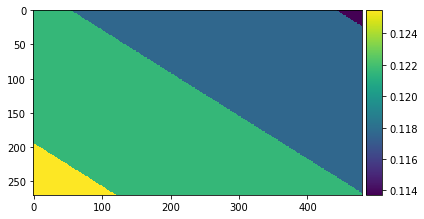

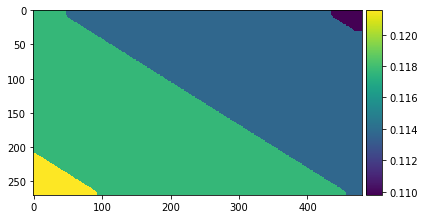

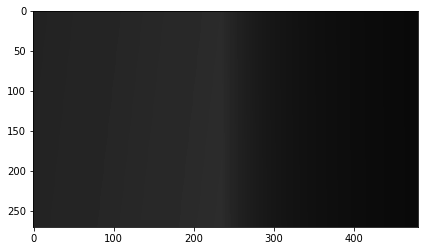

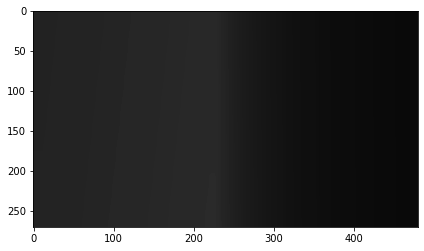

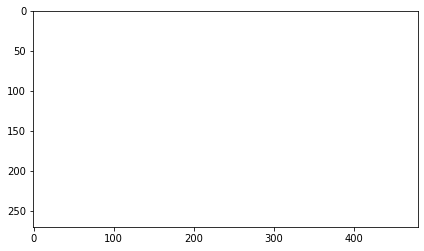

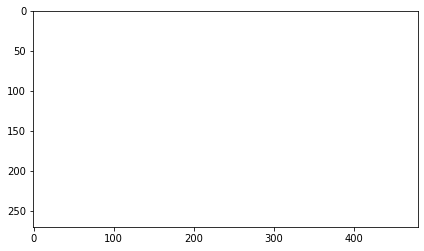

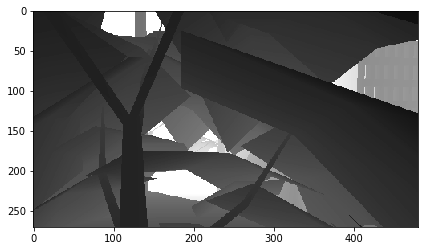

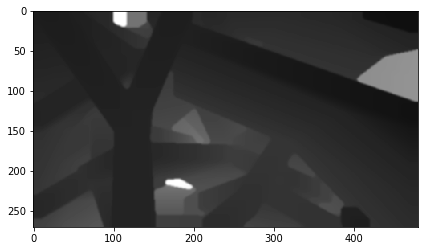

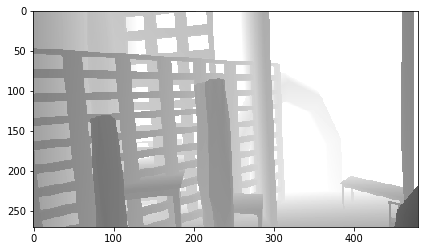

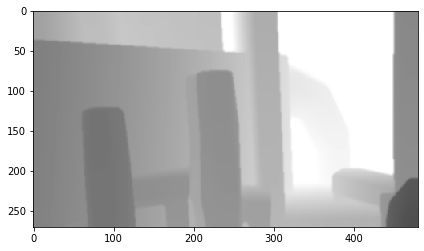

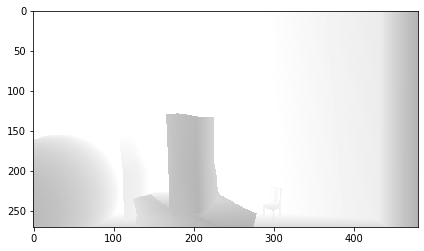

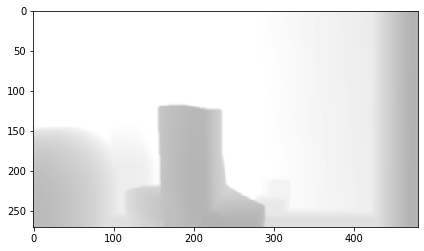

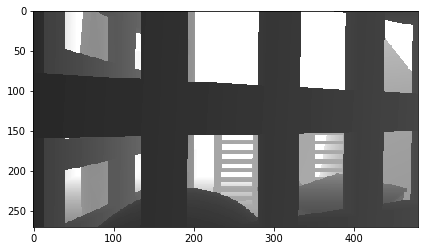

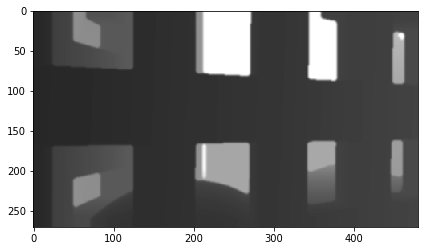

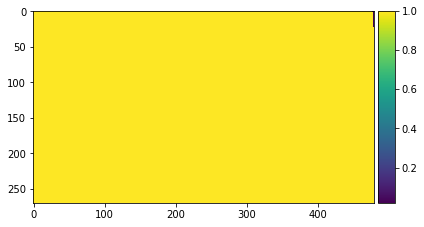

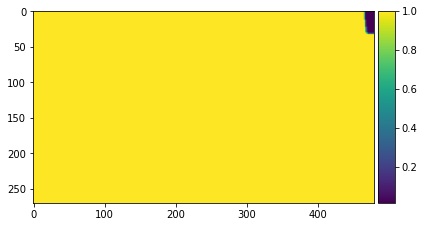

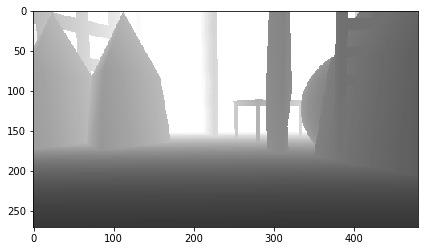

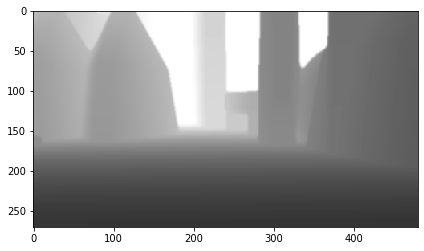

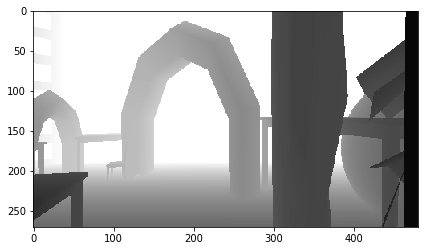

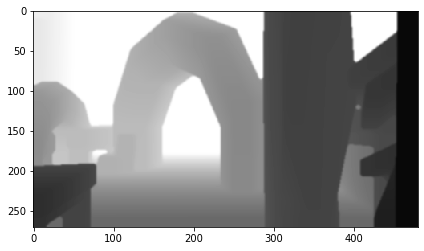

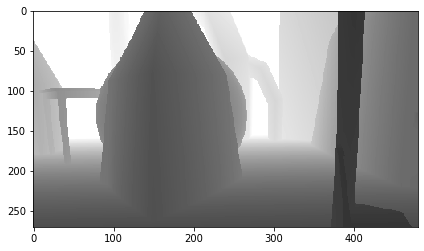

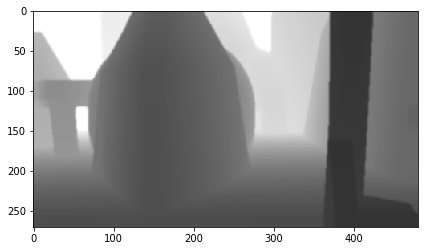

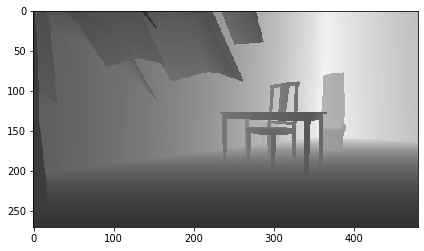

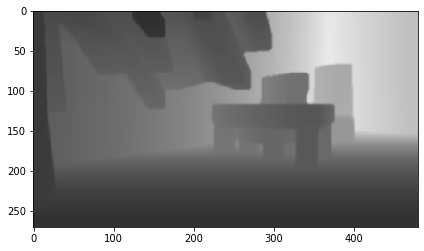

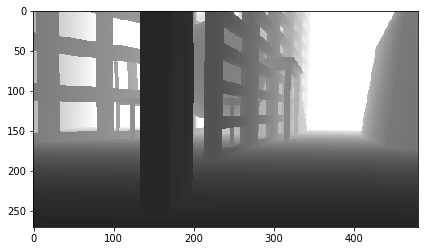

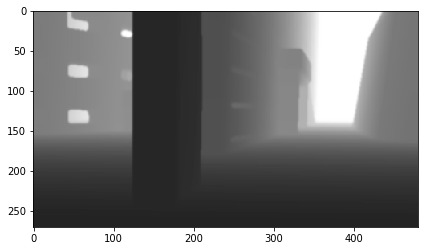

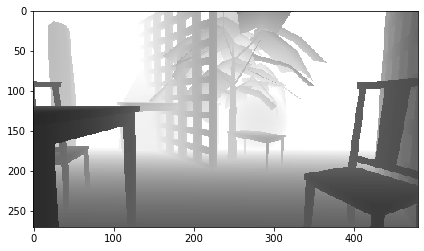

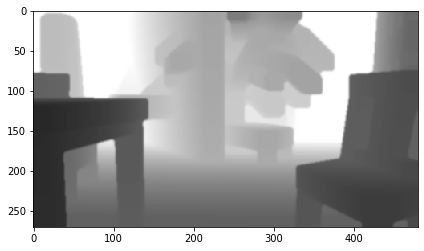

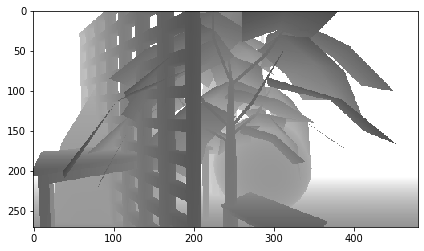

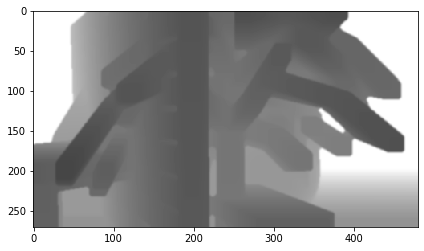

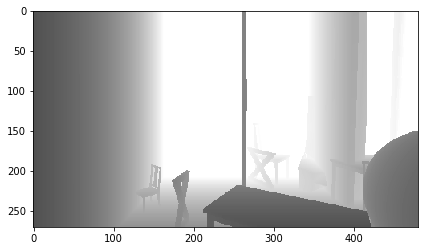

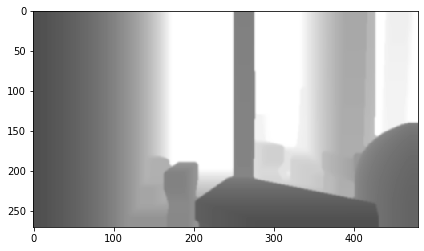

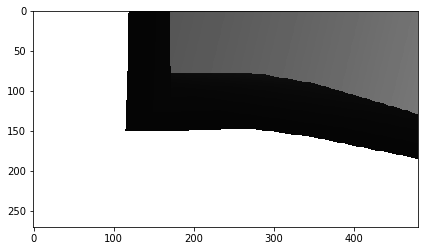

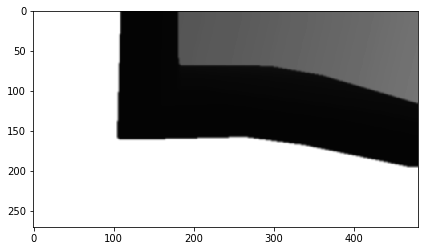

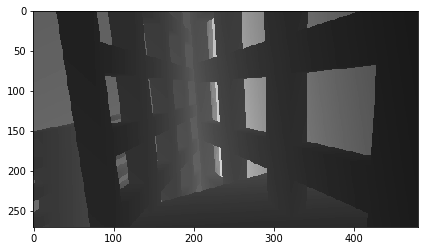

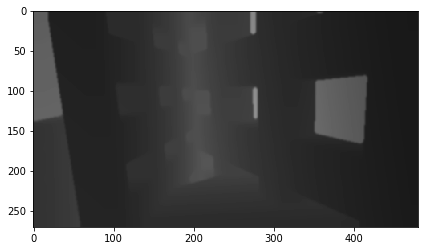

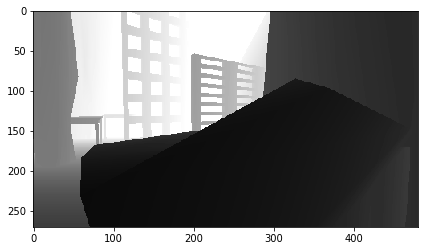

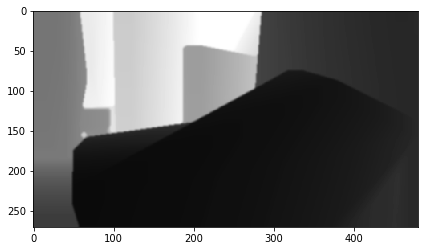

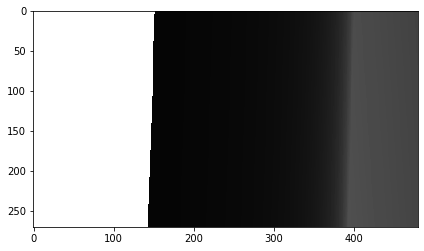

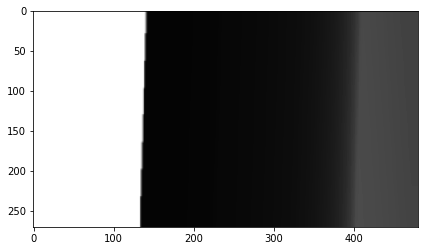

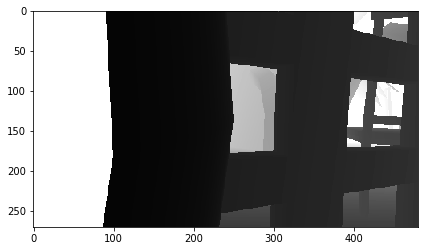

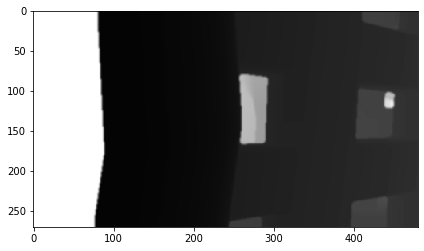

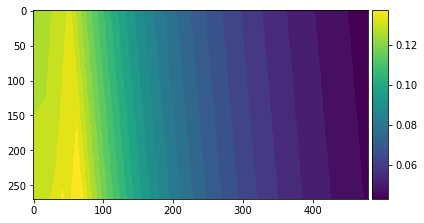

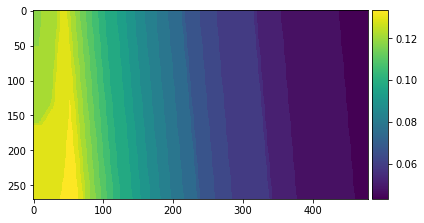

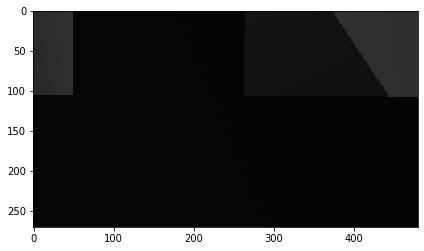

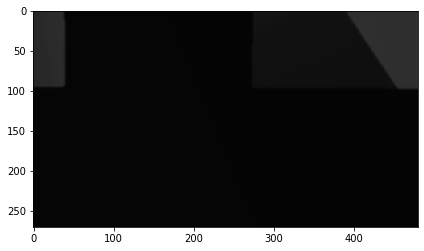

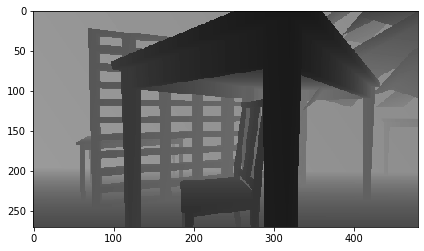

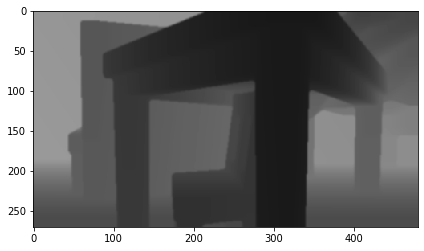

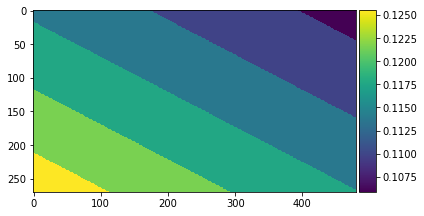

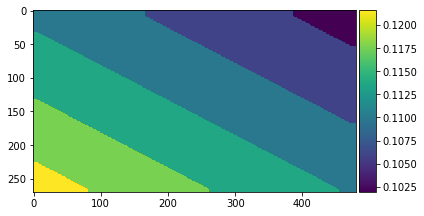

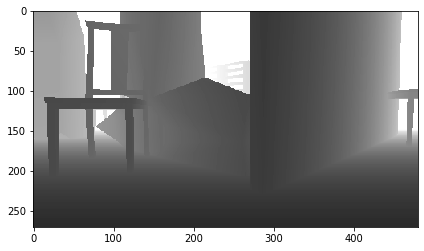

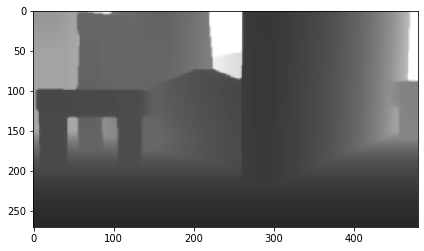

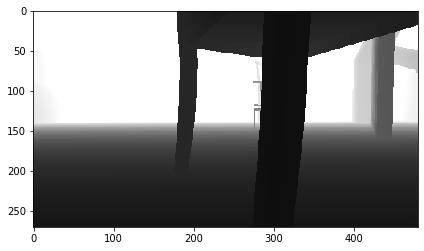

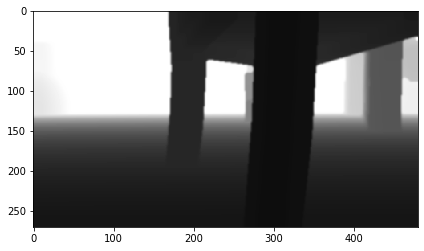

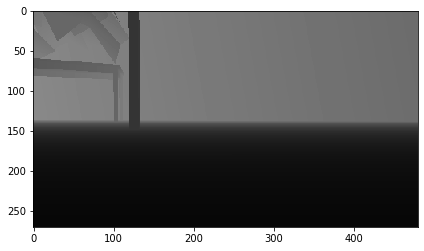

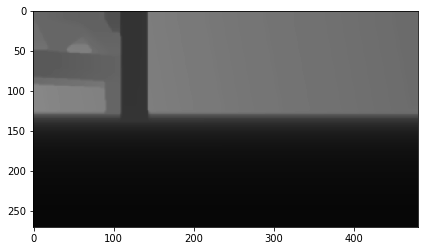

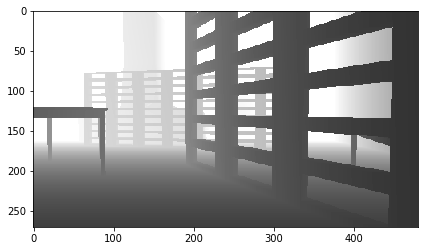

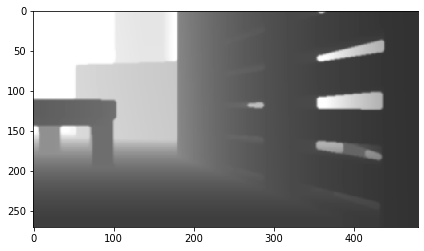

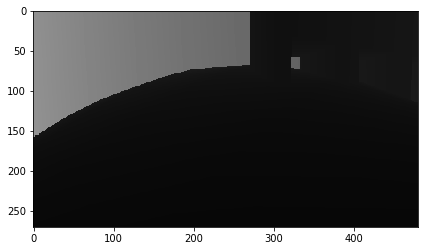

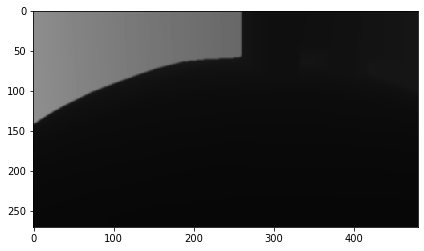

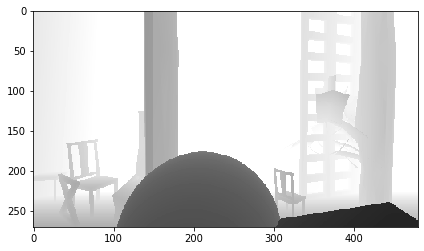

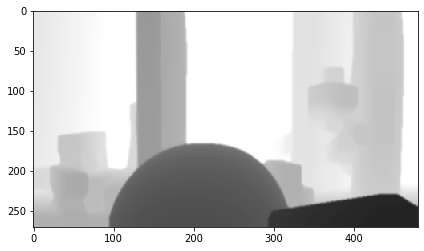

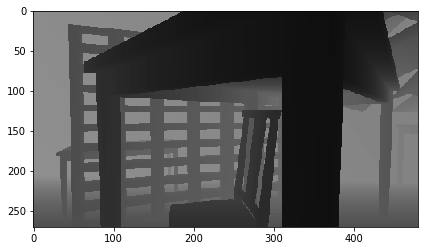

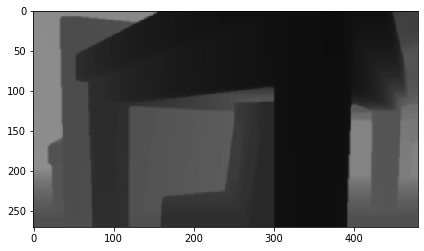

In [9]:
for i in range(32):
    img_idx = i
    image = images[img_idx]
    filtered = images_filtered[img_idx]
    
    io.imshow(image.numpy().squeeze())
    io.show()

    io.imshow(filtered.numpy().squeeze())
    io.show()

In [ ]:
image, height, width, depth = iter(data_iter).next()
image.shape, height[0], width[0], depth[0]

In [ ]:
i = 0
for image, height, width, depth in loader:
    i += 1
    if (i+1) % 50 == 0:
        print(i+1, ":", image.shape)
len(loader)

In [ ]:
i = 0
for image, height, width, depth in loader:
    i += 1
    if (i+1) % 2 == 0:
        print(i+1, ":", image.shape)
len(loader)